In [1]:
import os
import numpy as np
import jams
import librosa
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [2]:
annotation_folder = "audio/GuitarSet/annotation/"
audio_folder = "audio/GuitarSet/audio/"
output = {}
hop_length = 512
sr_curr = 22050
cqt_n_bins = 288
cqt_bins_per_octave = 36
string_midi_pitches = [40,45,50,55,59,64]
highest_fret = 19
num_classes = highest_fret + 2
matrix = np.zeros(shape=(6, 21)).astype(int)

In [3]:
def preprocess_audio(data):
    data = data.astype(float)
    data = librosa.util.normalize(data)
    data = np.abs(librosa.cqt(data,
                              hop_length=hop_length,
                              sr=sr_curr,
                              n_bins=cqt_n_bins,
                              bins_per_octave=cqt_bins_per_octave))

    return data

In [4]:
def correct_numbering(n):
    n += 1
    if n < 0 or n > highest_fret+1:
        n = 0
    return n

def one_hot_encode(label):
    return to_categorical(label, num_classes)

In [5]:
def process_label(label):
    label = [correct_numbering(n) for n in label]
    return one_hot_encode(label)

In [6]:
def process_labels(labels):
    return np.array([process_label(label) for label in labels])

In [7]:
def load_data_from_file(filename):
    output = {}
    file_audio = audio_folder + filename + "_mic.wav"
    file_anno = annotation_folder + filename + ".jams"
    jam = jams.load(file_anno)
    data, _ = librosa.load(file_audio, sr=sr_curr)

    # preprocess audio, store in output dict
    output["spec"] = np.swapaxes(preprocess_audio(data),0,1)

    # construct labels
    frame_indices = range(len(output["spec"]))
    times = librosa.frames_to_time(frame_indices, sr = sr_curr, hop_length=hop_length)

    # loop over all strings and sample annotations
    labels = []
    for string_num in range(6):
        anno = jam.annotations["note_midi"][string_num]
        string_label_samples = anno.to_samples(times)
        # replace midi pitch values with fret numbers
        for i in frame_indices:
            if string_label_samples[i] == []:
                string_label_samples[i] = -1
            else:
                string_label_samples[i] = int(round(string_label_samples[i][0]) - string_midi_pitches[string_num])
        labels.append([string_label_samples])

    labels = np.array(labels)
    # remove the extra dimension
    labels = np.squeeze(labels)
    labels = np.swapaxes(labels,0,1)

    # clean labels
    labels = process_labels(labels)

    # store and return
    output["tab"] = labels
    labels = labels.astype(int)
    sum_labels = np.zeros((6, 21)).astype(int)
    for label in labels:
        sum_labels += label
    return sum_labels

In [8]:
for file in os.listdir(annotation_folder):
    file = file.replace('.jams', '')
    if file.startswith(''):
        l = load_data_from_file(file)
        matrix += l
        print(f"file {file} done")

file 00_BN1-129-Eb_comp done
file 00_BN1-129-Eb_solo done
file 00_BN1-147-Gb_comp done
file 00_BN1-147-Gb_solo done
file 00_BN2-131-B_comp done
file 00_BN2-131-B_solo done
file 00_BN2-166-Ab_comp done
file 00_BN2-166-Ab_solo done
file 00_BN3-119-G_comp done
file 00_BN3-119-G_solo done
file 00_BN3-154-E_comp done
file 00_BN3-154-E_solo done
file 00_Funk1-114-Ab_comp done
file 00_Funk1-114-Ab_solo done
file 00_Funk1-97-C_comp done
file 00_Funk1-97-C_solo done
file 00_Funk2-108-Eb_comp done
file 00_Funk2-108-Eb_solo done
file 00_Funk2-119-G_comp done
file 00_Funk2-119-G_solo done
file 00_Funk3-112-C#_comp done
file 00_Funk3-112-C#_solo done
file 00_Funk3-98-A_comp done
file 00_Funk3-98-A_solo done
file 00_Jazz1-130-D_comp done
file 00_Jazz1-130-D_solo done
file 00_Jazz1-200-B_comp done
file 00_Jazz1-200-B_solo done
file 00_Jazz2-110-Bb_comp done
file 00_Jazz2-110-Bb_solo done
file 00_Jazz2-187-F#_comp done
file 00_Jazz2-187-F#_solo done
file 00_Jazz3-137-Eb_comp done
file 00_Jazz3-137-Eb_

In [9]:
for l in matrix:
    print(str(l.tolist()[:11]).replace(',', ' &'))
print()
for l in matrix:
    print(str(l.tolist()[11:]).replace(',', ' &'))

[391605 & 14206 & 10547 & 8603 & 11749 & 11997 & 5728 & 10054 & 3193 & 2337 & 1382]
[341931 & 8633 & 4949 & 15087 & 18338 & 23117 & 10964 & 21806 & 8772 & 11183 & 3623]
[295941 & 10222 & 1981 & 18453 & 24220 & 17022 & 16413 & 27492 & 14570 & 22226 & 8580]
[284939 & 10936 & 10330 & 14937 & 19443 & 16445 & 17602 & 29853 & 20372 & 18261 & 10953]
[311630 & 11127 & 11526 & 11970 & 14274 & 15887 & 13596 & 22385 & 12848 & 17467 & 10300]
[391966 & 9563 & 5839 & 5427 & 7155 & 8415 & 7740 & 10041 & 4719 & 7719 & 4240]

[949 & 110 & 85 & 0 & 15 & 0 & 0 & 0 & 0 & 0]
[1845 & 1331 & 974 & 7 & 0 & 0 & 0 & 0 & 0 & 0]
[8574 & 4112 & 1930 & 639 & 87 & 23 & 8 & 7 & 39 & 21]
[9733 & 4466 & 2178 & 1239 & 164 & 624 & 26 & 35 & 24 & 0]
[8383 & 5140 & 2554 & 2341 & 519 & 355 & 215 & 29 & 0 & 14]
[4468 & 1777 & 1745 & 1197 & 288 & 105 & 145 & 11 & 0 & 0]


In [10]:
EStringLabels = matrix[0].tolist()[1:]
AStringLabels = matrix[1].tolist()[1:]
DStringLabels = matrix[2].tolist()[1:]
GStringLabels = matrix[3].tolist()[1:]
BStringLabels = matrix[4].tolist()[1:]
eStringLabels = matrix[5].tolist()[1:]
print(f"E string: {EStringLabels}")
print(f"A string: {AStringLabels}")
print(f"D string: {DStringLabels}")
print(f"G string: {GStringLabels}")
print(f"B string: {BStringLabels}")
print(f"e string: {eStringLabels}")

E string: [14206, 10547, 8603, 11749, 11997, 5728, 10054, 3193, 2337, 1382, 949, 110, 85, 0, 15, 0, 0, 0, 0, 0]
A string: [8633, 4949, 15087, 18338, 23117, 10964, 21806, 8772, 11183, 3623, 1845, 1331, 974, 7, 0, 0, 0, 0, 0, 0]
D string: [10222, 1981, 18453, 24220, 17022, 16413, 27492, 14570, 22226, 8580, 8574, 4112, 1930, 639, 87, 23, 8, 7, 39, 21]
G string: [10936, 10330, 14937, 19443, 16445, 17602, 29853, 20372, 18261, 10953, 9733, 4466, 2178, 1239, 164, 624, 26, 35, 24, 0]
B string: [11127, 11526, 11970, 14274, 15887, 13596, 22385, 12848, 17467, 10300, 8383, 5140, 2554, 2341, 519, 355, 215, 29, 0, 14]
e string: [9563, 5839, 5427, 7155, 8415, 7740, 10041, 4719, 7719, 4240, 4468, 1777, 1745, 1197, 288, 105, 145, 11, 0, 0]


In [11]:
def plot_distribution(distribution, labels, title, xlabel='', ylabel='', color='purple'):
    plt.figure(figsize=(10,5))
    plt.bar(labels, distribution, color=color, alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    plt.yticks(np.arange(0, 40000, step=10000))
    plt.show()

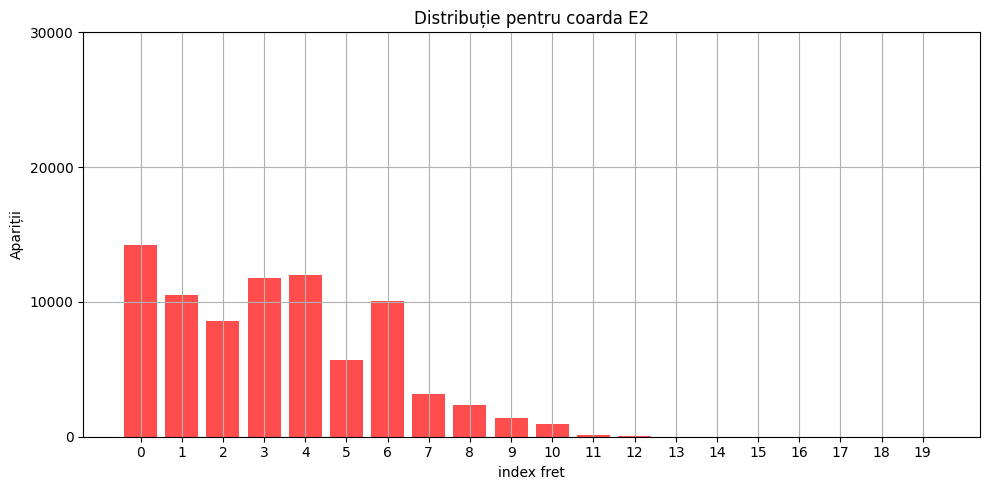

In [12]:
#E_labels = [str(i) for i in range(string_midi_pitches[0], string_midi_pitches[0] + highest_fret + 1)]
E_labels = [str(i) for i in range(0,20)]
plot_distribution(EStringLabels, E_labels, title='Distribuție pentru coarda E2', xlabel='index fret', ylabel='Apariții', color='red')

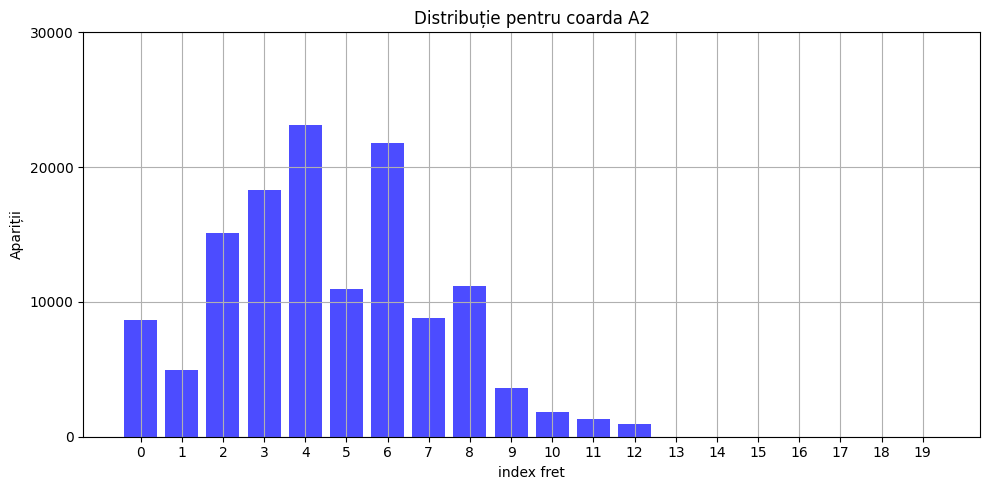

In [13]:
#A_labels = [str(i) for i in range(string_midi_pitches[1], string_midi_pitches[1] + highest_fret + 1)]
A_labels = [str(i) for i in range(0,20)]
plot_distribution(AStringLabels, A_labels, title='Distribuție pentru coarda A2', xlabel='index fret', ylabel='Apariții', color='blue')

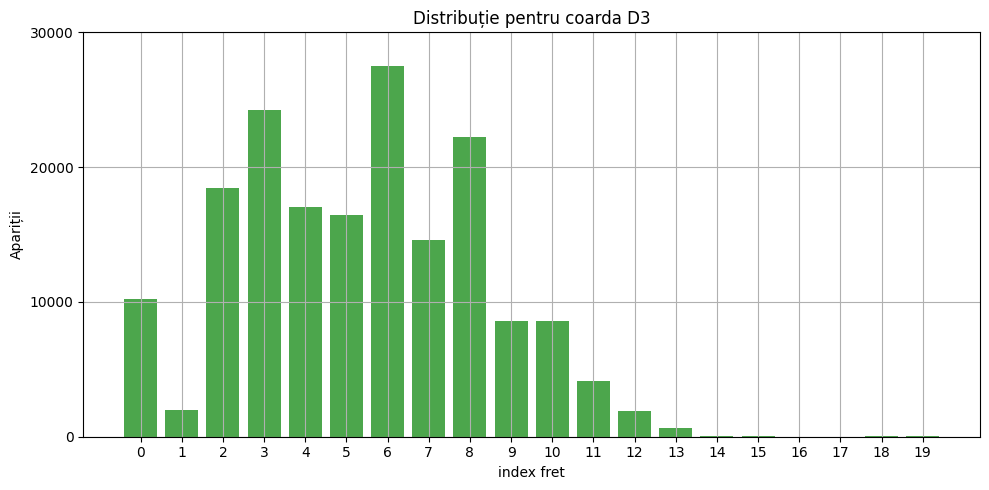

In [60]:
#D_labels = [str(i) for i in range(string_midi_pitches[2], string_midi_pitches[2] + highest_fret + 1)]
D_labels = [str(i) for i in range(0,20)]
plot_distribution(DStringLabels, D_labels, title='Distribuție pentru coarda D3', xlabel='index fret', ylabel='Apariții', color='green')

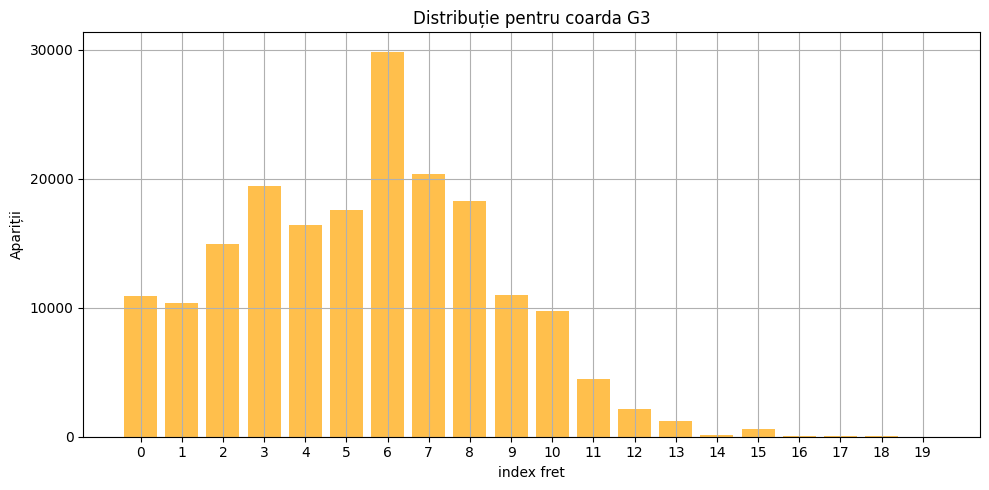

In [61]:
#G_labels = [str(i) for i in range(string_midi_pitches[3], string_midi_pitches[3] + highest_fret + 1)]
G_labels = [str(i) for i in range(0,20)]
plot_distribution(GStringLabels, G_labels, title='Distribuție pentru coarda G3', xlabel='index fret', ylabel='Apariții', color='orange')

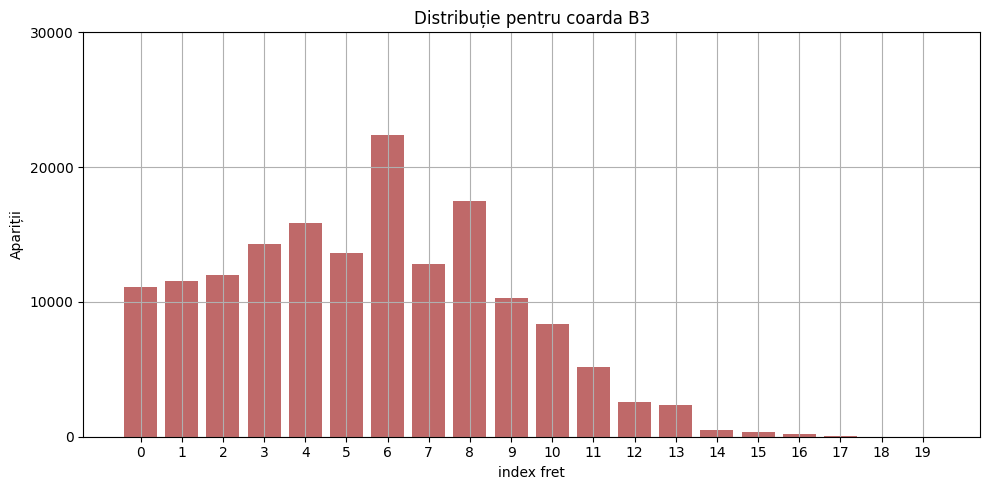

In [62]:
#B_labels = [str(i) for i in range(string_midi_pitches[4], string_midi_pitches[4] + highest_fret + 1)]
B_labels = [str(i) for i in range(0,20)]
plot_distribution(BStringLabels, B_labels, title='Distribuție pentru coarda B3', xlabel='index fret', ylabel='Apariții', color='brown')

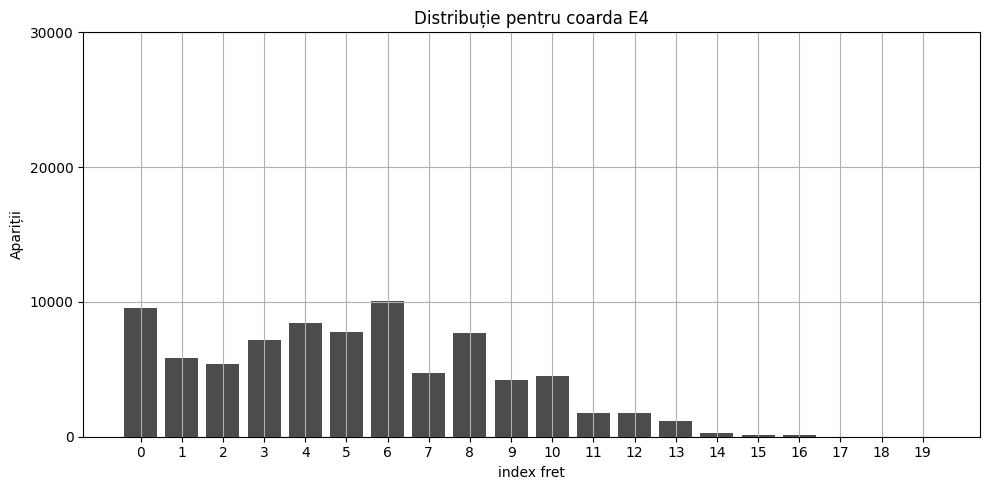

In [63]:
#e_labels = [str(i) for i in range(string_midi_pitches[5], string_midi_pitches[5] + highest_fret + 1)]
e_labels = [str(i) for i in range(0,20)]
plot_distribution(eStringLabels, e_labels, title='Distribuție pentru coarda E4', xlabel='index fret', ylabel='Apariții', color='black')

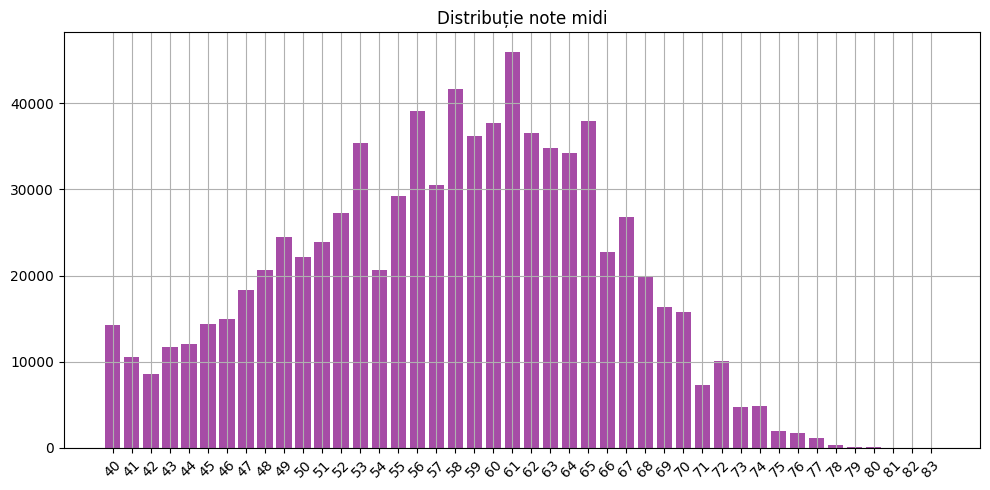

[14206.0, 10547.0, 8603.0, 11749.0, 11997.0, 14361.0, 15003.0, 18280.0, 20675.0, 24499.0, 22135.0, 23897.0, 27310.0, 35403.0, 20660.0, 29194.0, 39153.0, 30481.0, 41676.0, 36152.0, 37702.0, 45935.0, 36576.0, 34787.0, 34199.0, 37980.0, 22749.0, 26807.0, 19993.0, 16308.0, 15805.0, 7299.0, 10095.0, 4783.0, 4823.0, 1992.0, 1774.0, 1197.0, 302.0, 105.0, 145.0, 11.0, 0.0, 0.0]


In [49]:
pitch_distribution = np.zeros(44)
for string_index in range(6):
    string_distribution = matrix[string_index].tolist()[1:]
    for fret in range(0, highest_fret+1):
        pitch_distribution[string_midi_pitches[string_index] + fret - 40] += string_distribution[fret]


labels = np.array([str(i) for i in range(40, 84)])

plot_distribution(pitch_distribution, labels, title='Distribuție note midi')

print(pitch_distribution.tolist())